<a href="https://colab.research.google.com/github/makkimaki/VAEprojects/blob/master/Convolutional_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

from scipy.stats import norm

import glob
import imageio
import PIL
from IPython import display

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import metrics
from tensorflow.keras import backend as K
import tensorflow_probability as tfp
import time

np.random.seed(42)
print(tf.__version__)

2.3.0


In [3]:
(train_images, _), (test_images, _) = tf.keras.datasets.mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [4]:
train_images.shape

(60000, 28, 28)

In [5]:
def preprocess_images(images):
  images = images.reshape((images.shape[0], 28, 28, 1)) / 255.
  return np.where(images > 0.5, 1.0, 0.0).astype("float32")

train_images_preprocessed = preprocess_images(train_images)
test_images_preprocessed = preprocess_images(test_images)

In [6]:
train_images_preprocessed.shape

(60000, 28, 28, 1)

Text(0.5, 1.0, 'preprocessed image')

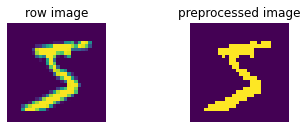

In [7]:
plt.figure(1)
plt.subplot(221)
plt.imshow(train_images[0, :, :])
plt.axis("off")
plt.title("row image")

plt.subplot(222)
plt.imshow(train_images_preprocessed[0, :, :, 0])
plt.axis("off")
plt.title("preprocessed image")

In [8]:
train_size = 60000
batch_size = 32
test_size = 10000

## Use tf.data to batch and shuffle the data

In [9]:
train_dataset = (tf.data.Dataset.from_tensor_slices(train_images_preprocessed).shuffle(train_size).batch(batch_size))
test_dataset = (tf.data.Dataset.from_tensor_slices(test_images_preprocessed).shuffle(test_size).batch(batch_size))

In [10]:
train_dataset

<BatchDataset shapes: (None, 28, 28, 1), types: tf.float32>

In [11]:
class CVAE(tf.keras.Model):
  """Convolutional variational autoencoder."""

  def __init__(self, latent_dim):
    super(CVAE, self).__init__()
    self.latent_dim = latent_dim
    self.encoder = tf.keras.Sequential(
        [
         tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
         tf.keras.layers.Conv2D(
             filters=32, kernel_size=3, strides=(2,2), activation="relu"),
         tf.keras.layers.Conv2D(
             filters=64, kernel_size=3, strides=(2,2), activation="relu"),
         tf.keras.layers.Flatten(),
         # no activation
         tf.keras.layeres.Dense(latent_dim + latend_dim),
        ]
    )

    self.decoder = tf.keras.Sequential(
        [
         tf.keras.layers.InputLayer(input_shape=(latent_dim,)),
         tf.keras.layers.Dense(units=7*7*32, activation="relu"),
         tf.keras.layers.Reshape(target_shape=(7,7,32)),
         tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding="same", activation="relu"),
         tf.keras.layers.Conv2DTranspose(filters=1, kernel_size=3, strides=1, padding="same")
        ]
    )

    @tf.function
    def sample(self, eps=None):
      if eps is None:
        eps = tf.random.normal(shape=(100, self.latent_dim))
      return self.decode(eps, apply_sigmoid=True)

    def encode(self, x):
      mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
      return mean, logvar

    def reparameterize(self, mean, logvar):
      eps = tf.random.normal(shape=mean.shape)
      return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, apply_sigmoid=False):
      logits = self.decoder(z)
      if apply_sigmoid:
        probs = tf.sigmoid(logits)
        return probs
      return logits

In [12]:
optimizer = tf.keras.optimizers.Adam(1e-4)

def log_normal_pdf(sample, mean, logvar, raxis=1):
  log2pi = tf.math.log(2 * np.pi)
  return tf.reduce_sum(
      -0.5 * ((sample - mean)**2 * tf.exp(-logvar) + logvar + log2pi), axis= raxis 
  )

def compute_loss(model, x):
  mean, logvar = model.encode(x)
  z = model.reparameterize(mean, logvar)
  x_logit = model.decode(z)
  cross_ent = tf.nn.sigmoid_cross_entropy_with_logits(logits=x_logit, labels=x)
  logpx_z = -tf.reduce_sum(cross_ent, axis=[1,2,3])
  logpz_x = log_normal_pdf(z, 0, 0)
  logqz_x = log_normal_pdf(z, mean, logvar)
  return -tf.reduce_mean(logpx_z + logpz - logqz_x)

@tf.function
def train_step(model, x, optimizer):
  """Executes one training step and returns the loss.

  This function computes the loss and gradients, and uses the latter to update the model's parameters.
  """
  with tf.GradientTape() as tape:
    loss = compute_loss(model, x)
  gradients = tape.gradient(loss, model.trainable_variables)
  optimizer.apply_gradients(zip(gradients, model.trainable_variables))